In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd


df = pd.read_csv('/content/drive/MyDrive/DATASET/uber-raw-data-apr14.csv')


df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


start_time = pd.Timestamp('2014-04-04 16:00:00')
end_time = pd.Timestamp('2014-04-04 19:00:00')


df = df.loc[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)]


df.to_csv('Time.csv', index=False)


In [ ]:
df = pd.read_csv('/content/Time.csv')
df.drop(['datetime','week','Base','Date'], axis=1, inplace=True)
df.to_csv('/content/Time.csv', index = False)
df = pd.read_csv("/content/Time.csv")
df.head()

,Lat,Lon,Time
0,40.7404,-73.9961,16:00:00
1,40.7740,-73.8715,16:00:00
2,40.7502,-73.9733,16:01:00
3,40.7446,-73.9852,16:01:00
4,40.7574,-73.9691,16:02:00


In [ ]:
import pandas as pd


df = pd.read_csv('/content/drive/MyDrive/DATASET/NYC_BS.csv')

df.head()

,File no.,Reg,latitude,longitude
0,A0596560,1002506,40.712056,-74.013194
1,A0374984,1006424,40.717500,-74.008889
2,A0008691,1007303,40.710833,-74.001667
3,A0008692,1007304,40.708333,-74.009444
4,A0205494,1044316,40.705278,-74.009722


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans

# Read data
data = pd.read_csv('Time.csv')
X = data[['Lat', 'Lon']].values

# Define number of clusters
k = len(X) // 20+1

# Fit KMeans model
kmeans = KMeans(n_clusters=k,random_state=42).fit(X)

# Get cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Compute distances and save results to files
centroid_data = pd.DataFrame(columns=['centroid_index', 'latitude', 'longitude', 'num_locations'])
location_data = pd.DataFrame(columns=['centroid_index', 'latitude', 'longitude'])
for i in range(len(X)):
    centroid_index = labels[i]
    latitude, longitude = X[i]
    location_data.loc[i] = [centroid_index, latitude, longitude]

distances = sum(((X[j][0]-centroids[i][0])**2 + (X[j][1]-centroids[i][1])**2)**0.5 for i in range(k) for j in range(len(X)) if labels[j]==i)

centroid_data['centroid_index'] = range(k)
centroid_data['latitude'] = centroids[:, 0]
centroid_data['longitude'] = centroids[:, 1]
centroid_data['num_locations'] = [sum(labels == i) for i in range(k)]

location_data.to_csv('user_location_data.csv', index=False)
centroid_data.to_csv('centroid_data.csv', index=False)

# Print cluster information
for i in range(k):
    indices = labels == i
    print(f'Cluster {i}:')
    print(f'\tCentroid: {centroids[i]}')
    print(f'\tNumber of locations: {indices.sum()}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
	Centroid: [ 40.778275  -73.9881125]
	Number of locations: 16
Cluster 1:
	Centroid: [ 40.74451562 -73.98799531]
	Number of locations: 64
Cluster 2:
	Centroid: [ 40.6713 -73.8442]
	Number of locations: 2
Cluster 3:
	Centroid: [ 40.6865625 -73.9678   ]
	Number of locations: 8
Cluster 4:
	Centroid: [ 40.77899565 -73.95600435]
	Number of locations: 23
Cluster 5:
	Centroid: [ 40.71719189 -74.00392432]
	Number of locations: 37
Cluster 6:
	Centroid: [ 40.68923333 -74.18173333]
	Number of locations: 3
Cluster 7:
	Centroid: [ 40.77402692 -73.87231538]
	Number of locations: 26
Cluster 8:
	Centroid: [ 40.75958283 -73.97172727]
	Number of locations: 99
Cluster 9:
	Centroid: [ 40.7791 -73.5736]
	Number of locations: 1
Cluster 10:
	Centroid: [ 40.64557895 -73.78224211]
	Number of locations: 19
Cluster 11:
	Centroid: [ 40.8866 -73.7847]
	Number of locations: 1
Cluster 12:
	Centroid: [ 40.8723 -74.4458]
	Number of locations: 1
Cluster 13:
	Centroid: [ 40.8675 -73.9539]
	Number of locations:

In [ ]:
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

medoids_df = pd.read_csv('centroid_data.csv')
base_stations_df = pd.read_csv('/content/drive/MyDrive/DATASET/NYC_BS.csv')

medoid_to_base_station = {}

for i, medoid_row in medoids_df.iterrows():
    medoid_lat, medoid_lon = radians(medoid_row['latitude']), radians(medoid_row['longitude'])
    min_distance = float('inf')
    nearest_base_station = None

    for j, base_station_row in base_stations_df.iterrows():
        base_station_lat, base_station_lon = radians(base_station_row['latitude']), radians(base_station_row['longitude'])
        dlat = base_station_lat - medoid_lat
        dlon = base_station_lon - medoid_lon
        a = sin(dlat / 2)**2 + cos(medoid_lat) * cos(base_station_lat) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        dist = 6371 * c  # radius of earth in km

        if dist < min_distance:
            min_distance = dist
            nearest_base_station = base_station_row['Reg']

    medoid_to_base_station[i] = {
        'centroid_index': medoid_row['centroid_index'],
        'nearest_base_station': nearest_base_station,
        'distance_to_base_station_km': min_distance,
        'no.of users':medoid_row['num_locations']
    }

result_df = pd.DataFrame.from_dict(medoid_to_base_station, orient='index')
result_df.to_csv('centroid_to_nearest_base_stations.csv', index=False)


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('centroid_to_nearest_base_stations.csv')


cols_to_normalize = ['distance_to_base_station_km', 'no.of users']
data_to_normalize = df[cols_to_normalize]

scaler = MinMaxScaler()

scaler.fit(data_to_normalize)

normalized_data = scaler.transform(data_to_normalize)

df[cols_to_normalize] = normalized_data

df.to_csv('normalized_data.csv', index=False)

In [ ]:
!pip install pulp
import pandas as pd
from pulp import *


df = pd.read_csv('normalized_data.csv')
num_users_1 = pd.read_csv('normalized_data.csv', usecols=['no.of users'])

n_col = 'no.of users'
d_col = 'distance_to_base_station_km'

# calculate the weighted score with varying 'a' values
a_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

offloading_data = []

for num_deployed_uavbs in range(1, 11):

    offloading_percentages = []

    for a in a_values:

        # calculate the weighted score with the current 'a' value
        df['WS'] = a * df[n_col] + (1 - a) * df[d_col]

        # solve the CSP problem
        K = len(df)
        W = df['WS'].values.reshape((K, 1))
        num_users = df[n_col].values.reshape((K, 1))

        prob = LpProblem(f"CSP Problem (num_deployed_uavbs={num_deployed_uavbs}, a={a})", LpMaximize)

        z = LpVariable.dicts("z", range(K), cat='Binary')

        prob += lpSum(W[k] * z[k] for k in range(K))

        prob += lpSum([z[k] for k in range(K)]) == num_deployed_uavbs

        prob.solve()

        # calculate the offloading percentage and selected cluster index
        if LpStatus[prob.status] == 'Optimal':

            offloading_percentage = 0
            sum_users = 0
            selected_clusters = []
            for k in range(K):
                if z[k].value() == 1:
                    sum_users += num_users_1.iloc[k].values[0]
                    selected_clusters.append(k)
            offloading_percentage = (20*num_deployed_uavbs)/sum_users
            offloading_percentages.append(offloading_percentage)
            print(sum_users)



    # finding the 'a' value that maximizes the offloading percentage
    max_offloading_percentage = min(offloading_percentages)
    max_a_index = offloading_percentages.index(max_offloading_percentage)
    max_a = a_values[max_a_index]

    # add the offloading percentage data to the output list
    offloading_data.append([num_deployed_uavbs, max_a, max_offloading_percentage])

# saving the output to a CSV file
output_df = pd.DataFrame(offloading_data, columns=['Num Deployed UAV-BSs', 'Maximized a', 'Offloading Percentage'])
output_df.to_csv('offloading_data.csv', index=False)
df.sort_values(by='WS', ascending=False, inplace=True)

# Saving the output to a CSV file with centroid index and WS
outputs_df = df[['centroid_index', 'WS']]
outputs_df.to_csv('output_data.csv', index=False)




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 19.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
<ipython-input-8-bf03df43691f>:51: RuntimeWarning: divide by zero encountered in double_scalars
  offloading_percentage = (20*num_deployed_uavbs)/sum_users


0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.9897959183673468
1.9897959183673468
1.9897959183673468
1.9897959183673468
1.9897959183673468
1.9897959183673468
0.0
0.0
0.0
0.0
1.9897959183673468
2.8775510204081627
2.8775510204081627
2.8775510204081627
2.8775510204081627
2.8775510204081627
0.0
0.0
0.0
1.0
2.8775510204081627
3.6938775510204076
3.6938775510204076
3.6938775510204076
3.6938775510204076
3.6938775510204076
0.0
0.0
0.0
1.9897959183673468
3.6938775510204076
4.499999999999999
4.499999999999999
4.499999999999999
4.499999999999999
4.499999999999999
0.0
0.0
0.0
1.9897959183673468
4.499999999999999
5.295918367346938
5.295918367346938
5.295918367346938
5.295918367346938
5.295918367346938
0.0
0.0
0.0
2.8775510204081627
5.295918367346938
6.051020408163264
6.051020408163264
6.051020408163264
6.051020408163264
6.051020408163264
0.0
0.0
0.0
2.8775510204081627
5.295918367346938
6.765306122448979
6.765306122448979
6.765306122448979
6.765306122448979
6.765306122448979
0.0
0.0
1.0
3

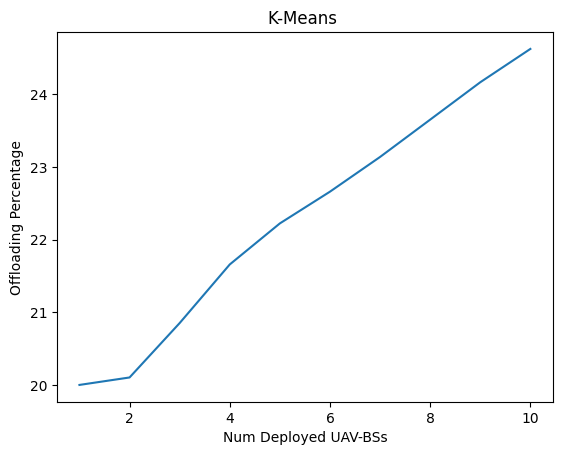

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('offloading_data.csv')
x = df['Num Deployed UAV-BSs']
y = df['Offloading Percentage']
plt.plot(x, y)
plt.xlabel('Num Deployed UAV-BSs')
plt.ylabel('Offloading Percentage')
plt.title('K-Means ')
plt.savefig('plot.png')
plt.show()




In [ ]:
import pandas as pd

# Load the user_location_data and output CSV files
user_location_data = pd.read_csv("user_location_data.csv")
output = pd.read_csv("output_data.csv")

# Sort the output dataframe by 'WS' in descending order and select the top 2 rows
top_centroids = output.sort_values(by='WS', ascending=False).head(2)

# Extract the centroid indices from the top 2 rows
top_indices = top_centroids['centroid_index']

# Filter user_location_data based on the top centroid indices
filtered_data = user_location_data[user_location_data['centroid_index'].isin(top_indices)]

# Extract latitude and longitude columns for the top centroid indices
result = filtered_data[['centroid_index', 'latitude', 'longitude']]

result.to_csv("user_locations.csv", index=False)



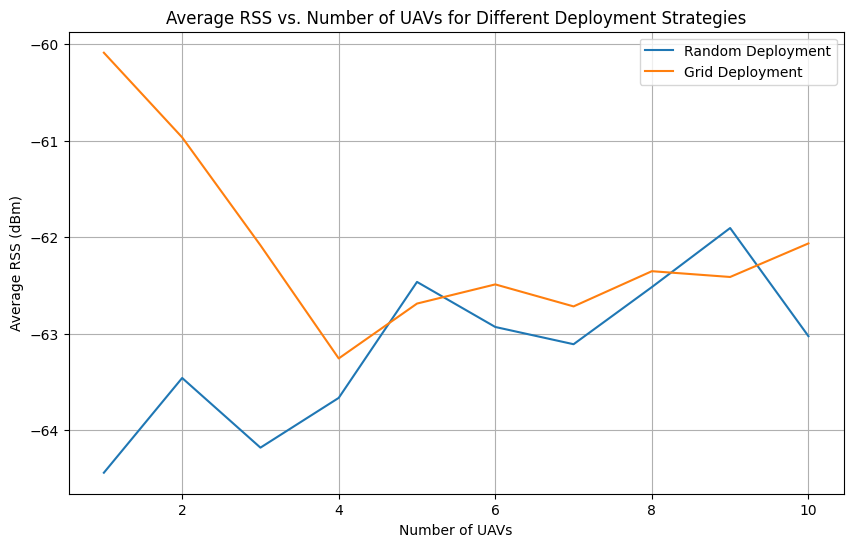

In [ ]:
import random
import math
import csv
import matplotlib.pyplot as plt

# Constants
Pt_dBm = 23  # Transmit power in dBm
Gt_dBi = 0   # Transmitter antenna gain in dBi
Gr_dBi = 0   # Receiver antenna gain in dBi
c = 3e8      # Speed of light (m/s)
frequency = 1.8e9  # Frequency in Hz (2.4 GHz)
altitude = 100  # UAV altitude in meters (adjust as needed)

# Elevation angle-based path loss model
def elevation_angle_path_loss(elevation_angle, distance):
    wavelength = c / frequency
    path_loss_dB = 20 * math.log10(4 * math.pi * distance / wavelength)
    return path_loss_dB

# Function to calculate distance between two points using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    distance = R * c  # Distance in kilometers
    return distance * 1000  # Convert to meters


# Read user locations from a CSV file (assuming columns 'Latitude' and 'Longitude')
user_locations = []
with open('user_locations.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        user_lat = float(row['latitude'])
        user_lon = float(row['longitude'])
        user_locations.append((user_lat, user_lon))

min_lat = min(user_locations, key=lambda x: x[0])[0]
max_lat = max(user_locations, key=lambda x: x[0])[0]
min_lon = min(user_locations, key=lambda x: x[1])[1]
max_lon = max(user_locations, key=lambda x: x[1])[1]

# Function to calculate average RSS for a given deployment strategy and number of UAVs
def calculate_average_rss(deployment_strategy, num_uavs):
    total_rss = 0
    for _ in range(num_uavs):
        if deployment_strategy == 'random':
            # Random UAV deployment
            uav_location = (random.uniform(min_lat, max_lat), random.uniform(min_lon, max_lon))
        elif deployment_strategy == 'grid':
            # Grid-based UAV deployment
            uav_lat = random.uniform(min_lat, max_lat)
            uav_lon = random.uniform(min_lon, max_lon)
            uav_location = (uav_lat, uav_lon)

        total_path_loss = 0
        for user_location in user_locations:
            distance = haversine(user_location[0], user_location[1], uav_location[0], uav_location[1])
            elevation_angle = math.degrees(math.atan(altitude / distance))
            path_loss_dB = elevation_angle_path_loss(elevation_angle, distance)
            total_path_loss += path_loss_dB

        average_path_loss = total_path_loss / len(user_locations)
        average_RSS_dBm = Pt_dBm - average_path_loss + Gt_dBi + Gr_dBi
        total_rss += average_RSS_dBm

    return total_rss / num_uavs  # Average RSS over UAVs

# Number of UAVs to deploy
num_uavs_range = list(range(1, 11))

# Calculate average RSS for random deployment and grid deployment
average_rss_random = [calculate_average_rss('random', num_uavs) for num_uavs in num_uavs_range]
average_rss_grid = [calculate_average_rss('grid', num_uavs) for num_uavs in num_uavs_range]

with open('average_rss_random.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Number of UAVs', 'Average RSS (dBm)'])
    for num_uavs, rss in zip(num_uavs_range, average_rss_random):
        writer.writerow([num_uavs, rss])

with open('average_rss_grid.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Number of UAVs', 'Average RSS (dBm)'])
    for num_uavs, rss in zip(num_uavs_range, average_rss_grid):
        writer.writerow([num_uavs, rss])

# Create a graph to display average RSS for different numbers of UAVs
plt.figure(figsize=(10, 6))
plt.plot(num_uavs_range, average_rss_random, label='Random Deployment')
plt.plot(num_uavs_range, average_rss_grid, label='Grid Deployment')

plt.xlabel('Number of UAVs')
plt.ylabel('Average RSS (dBm)')
plt.title('Average RSS vs. Number of UAVs for Different Deployment Strategies')
plt.legend()
plt.grid(True)
plt.show()


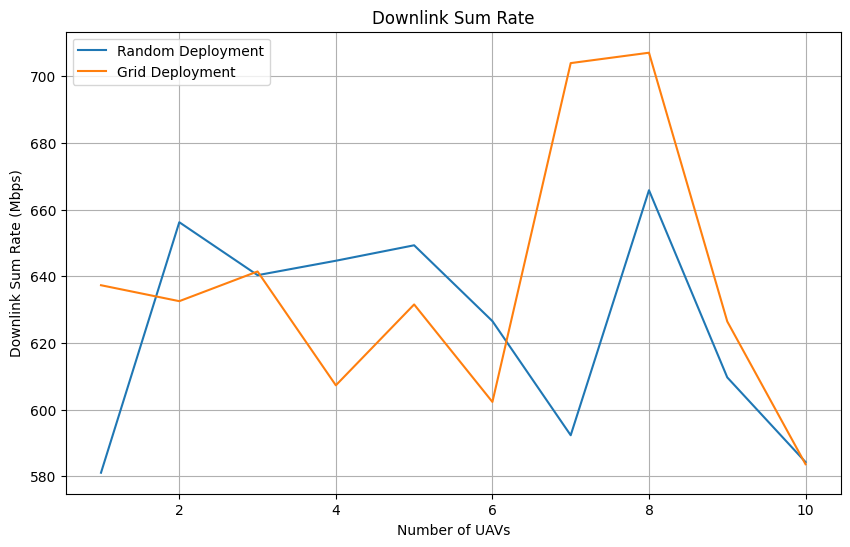

In [ ]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

# Constants
bandwidth = 5e6  # Bandwidth in Hz (5 MHz)
noise_power_dBm = -174 + 10 * math.log10(bandwidth)  # Noise power in dBm
shadowing_std_dev = 6.0  # Standard deviation of log-normal shadowing in dB

# Function to calculate log-normal shadowing values
def generate_shadowing(num_samples):
    shadowing = np.random.normal(0, shadowing_std_dev, num_samples)
    return shadowing

# Function to calculate downlink sum rate (bps) with log-normal shadowing
def calculate_downlink_sum_rate(deployment_strategy, num_uavs):
    # Load average RSS from CSV file
    with open(f'average_rss_{deployment_strategy}.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        average_rss = [float(row[1]) for row in reader]

    num_samples = len(average_rss)

    # Calculate log-normal shadowing values for each sample
    shadowing = generate_shadowing(num_samples)

    # Calculate SNR (Signal-to-Noise Ratio) for each RSS value with shadowing
    snr_values = [10 ** ((rss - noise_power_dBm + shadow - shadowing_std_dev) / 10) for rss, shadow in zip(average_rss, shadowing)]

    # Calculate downlink sum rate for the scenario
    sum_rate = sum([bandwidth * math.log2(1 + snr) for snr in snr_values]) / 1e6  # Sum rate in Mbps

    return sum_rate

# Number of UAVs to deploy
num_uavs_range = list(range(1, 11))

# Calculate downlink sum rate with log-normal shadowing for random deployment and grid deployment
sum_rate_random = [calculate_downlink_sum_rate('random', num_uavs) for num_uavs in num_uavs_range]
sum_rate_grid = [calculate_downlink_sum_rate('grid', num_uavs) for num_uavs in num_uavs_range]

with open('downlink_sum_rate_random.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Number of UAVs', 'Downlink Sum Rate (Mbps)'])
    for num_uavs in num_uavs_range:
        sum_rate = calculate_downlink_sum_rate('random', num_uavs)
        writer.writerow([num_uavs, sum_rate])

with open('downlink_sum_rate_grid.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Number of UAVs', 'Downlink Sum Rate (Mbps)'])
    for num_uavs in num_uavs_range:
        sum_rate = calculate_downlink_sum_rate('grid', num_uavs)
        writer.writerow([num_uavs, sum_rate])

# Create a graph to display downlink sum rate for different numbers of UAVs
plt.figure(figsize=(10, 6))
plt.plot(num_uavs_range, sum_rate_random, label='Random Deployment')
plt.plot(num_uavs_range, sum_rate_grid, label='Grid Deployment')

plt.xlabel('Number of UAVs')
plt.ylabel('Downlink Sum Rate (Mbps)')
plt.title('Downlink Sum Rate')
plt.legend()
plt.grid(True)
plt.show()


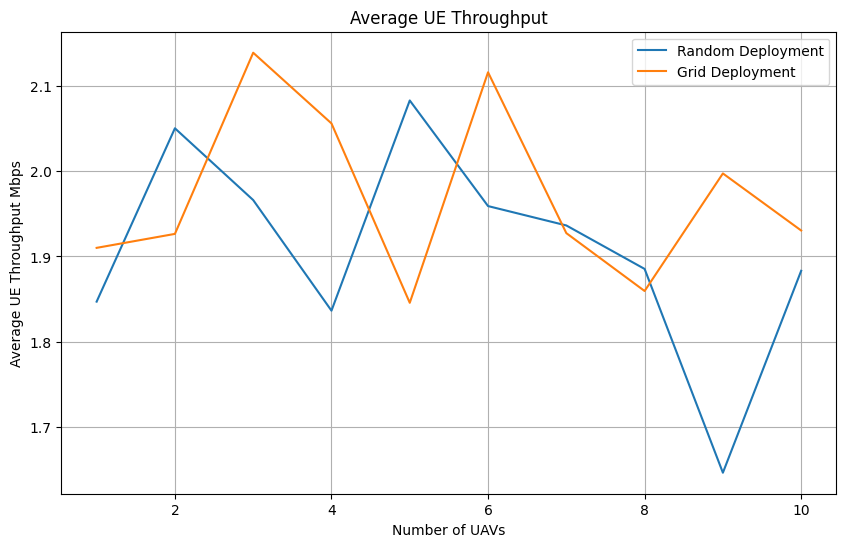

In [ ]:
import csv
import matplotlib.pyplot as plt

# Function to read the CSV file containing user information
def read_user_info(filename):
    num_users = 0
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            num_users += 1
    return num_users

# Function to read CSV files and calculate average UE throughput
def calculate_average_ue_throughput(filename, num_users):
    num_uavs = []
    sum_rates = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            num_uavs.append(int(row['Number of UAVs']))
            sum_rates.append(float(row['Downlink Sum Rate (Mbps)']))

    ue_throughput = [sum_rate / num_users for sum_rate in sum_rates]

    return num_uavs, ue_throughput

# Read the number of users from the CSV file containing user information
user_info_filename = 'output_data.csv'  # Replace with your user information CSV file
num_users = read_user_info(user_info_filename)

# Read CSV files for both deployment strategies
num_uavs_random, ue_throughput_random = calculate_average_ue_throughput('downlink_sum_rate_random.csv', num_users)
num_uavs_grid, ue_throughput_grid = calculate_average_ue_throughput('downlink_sum_rate_grid.csv', num_users)

# Create a graph to display average UE throughput for different numbers of UAVs
plt.figure(figsize=(10, 6))
plt.plot(num_uavs_random, ue_throughput_random, label='Random Deployment')
plt.plot(num_uavs_grid, ue_throughput_grid, label='Grid Deployment')

with open('average_ue_throughput_random.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Number of UAVs', 'Average UE Throughput (Mbps/User)'])
    for num_uavs, throughput in zip(num_uavs_random, ue_throughput_random):
        writer.writerow([num_uavs, throughput])

with open('average_ue_throughput_grid.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Number of UAVs', 'Average UE Throughput (Mbps/User)'])
    for num_uavs, throughput in zip(num_uavs_grid, ue_throughput_grid):
        writer.writerow([num_uavs, throughput])

plt.xlabel('Number of UAVs')
plt.ylabel('Average UE Throughput Mbps')
plt.title('Average UE Throughput')
plt.legend()
plt.grid(True)
plt.show()
